In [1]:
import visual_behavior_glm.GLM_params as glm_params
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_visualization_tools as gvt
from visual_behavior_glm.glm import GLM
import matplotlib.pyplot as plt
import visual_behavior.data_access.loading as loading
import visual_behavior.database as db
import plotly.express as px

import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import os

import seaborn as sns

import visual_behavior.plotting as vbp

import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sns.__version__

'0.11.0'

In [4]:
%matplotlib notebook
%widescreen

applied a custom magic command to make full use of screen width
will only work if command is defined locally
replace with the following to replicate functionality: 
	from IPython.core.display import display, HTML
	display(HTML("<style>.container { width:100% !important; }</style>")


# Gather/organize data

## load the results summary for a single GLM version from mongo

In [5]:
rs = gat.retrieve_results(search_dict = {'glm_version': '6_L2_optimize_by_session'}, results_type='summary')
rs.sample(10)

_id                    dropout  \
2471492  5f515fdb9cdb67c1671a890e     single-correct_rejects   
390052   5f4fd1ae2ead34eabb57ce05                 all-images   
704457   5f4fd1d4cb45a5a833671831           single-omissions   
895450   5f4fd2118fd1e8a8bb12ffcf  single-face_motion_energy   
3338997  5f52287e62765a27c3fd367c                     image2   
2182357  5f514bb222f3deb90f3fcf5c              single-image3   
2346623  5f515772fed8b64dd1ad855c                 all-images   
1370821  5f4fd7a7562deeef6b36fae5              single-image2   
2380389  5f51594626ca4af71cf1984b                       Full   
3191959  5f521b3004c5114ece28f2c7              single-image3   

         absolute_change_from_full  variance_explained  \
2471492                  -0.005912            0.000000   
390052                   -0.024199            0.092369   
704457                    0.000000            0.000000   
895450                   -0.049481            0.002338   
3338997                   0.000000            0.000000   
2182357                   0.000000            0.000000   
2346623                   0.000000            0.000000   
1370821                   0.000000            0.000000   
2380389                   0.000000            0.023397   
3191959                  -0.200640            0.005858   

         variance_explained_full  fraction_change_from_full  cell_specimen_id  \
2471492                 0.005912                   0.000000        1017240218   
390052                  0.116568                  -0.207593        1028804820   
704457                  0.000000                   0.000000        1016932270   
895450                  0.051819                   0.000000        1028791939   
3338997                 0.000000                   0.000000        1016987885   
2182357                 0.000000                   0.000000         982757009   
2346623                 0.000000                   0.000000        1008693714   
1370821                 0.000000                   0.000000        1028770237   
2380389                 0.023397                   0.000000        1028824589   
3191959                 0.206498                  -0.028370        1016989510   

         adj_fraction_change_from_full  adj_variance_explained  \
2471492                       0.000000                0.000043   
390052                       -0.208511                0.093440   
704457                        0.000000                0.000000   
895450                        0.000000                0.002337   
3338997                      -0.353689                0.004575   
2182357                       0.000000                0.000000   
2346623                       0.000000                0.000000   
1370821                       0.000000                0.000000   
2380389                       0.000000                0.023397   
3191959                      -0.792323                0.055615   

         adj_variance_explained_full  ophys_experiment_id  ophys_session_id  \
2471492                     0.000000            992084633         991958444   
390052                      0.118056            903485714         902884228   
704457                      0.000000            959389428         958905696   
895450                      0.051881            908381652         907991198   
3338997                     0.007078            968717800         968504496   
2182357                     0.000000            969430853         968218642   
2346623                     0.000000            853328115         852794147   
1370821                     0.000000            914580664         914161594   
2380389                     0.023397            875564411         870352564   
3191959                     0.070192            964615773         964046150   

         behavior_session_id  container_id                       project_code  \
2471492            991992557    1018027787           VisualBehaviorMultiscope   
390052             902995627    101

## get a list of columns to use for clustering. Defining this list now makes it easier to avoid accidentally clustering on some identifying feature (e.g., cre_line, session_type, etc.)
I'm removing the 'visual' dropout, since it's actually a combination of the omission and all-images dropouts.

In [76]:
cols_for_clustering = list(rs['dropout'].unique())
cols_to_exclude = [
    'Full',
    'visual',
]
cols_to_exclude = cols_to_exclude + [col for col in cols_for_clustering if 'single' in col]
cols_for_clustering = [col for col in cols_for_clustering if col not in cols_to_exclude]
cols_for_clustering

['all-images',
 'beh_model',
 'change',
 'correct_rejects',
 'false_alarms',
 'hits',
 'image0',
 'image1',
 'image2',
 'image3',
 'image4',
 'image5',
 'image6',
 'image7',
 'image_expectation',
 'intercept',
 'misses',
 'model_bias',
 'model_omissions1',
 'model_task0',
 'model_timing1D',
 'omissions',
 'post_lick_bouts',
 'post_licks',
 'pre_lick_bouts',
 'pre_licks',
 'pupil',
 'rewards',
 'running',
 'time',
 'face_motion_energy']

## build a pivoted version of the results summary, using the `fraction_change_from_full` column as the values.

In [77]:
rsp = gat.build_pivoted_results_summary(results_summary=rs, cutoff=0.01, value_to_use='adj_fraction_change_from_full')
rsp

identifier  Full  all-images  beh_model    change  \
0      1000743008_1003146172   0.0   -0.136583  -0.003512 -0.020345   
1      1000743008_1003146180   0.0   -0.175420   0.000000  0.000000   
2      1000743008_1003146183   0.0   -0.269375   0.000000 -0.021731   
3      1000743008_1003146186   0.0   -0.363167  -0.001300 -0.006254   
4      1000743008_1003146190   0.0   -0.114692  -0.001413 -0.017809   
...                      ...   ...         ...        ...       ...   
46501    995622557_994309976   0.0   -0.429839        NaN  0.000000   
46502    995622557_994309982   0.0   -0.482972        NaN  0.000000   
46503    995622557_994309993   0.0   -0.834681        NaN  0.000000   
46504    995622557_994309997   0.0   -0.486048        NaN  0.000000   
46505    995622557_994310003   0.0   -0.859033        NaN -0.002077   

       correct_rejects  face_motion_energy  false_alarms      hits    image0  \
0            -0.023242           -0.044587     -0.045372 -0.008406 -0.039902   
1             0.000000            0.000000     -0.134485 -0.009179  0.000000   
2            -0.004215           -0.012012     -0.019177 -0.015448 -0.118272   
3            -0.000940           -0.011914      0.000000  0.000000  0.000000   
4             0.000000            0.000000      0.000000 -0.002697 -0.030255   
...                ...                 ...           ...       ...       ...   
46501         0.000000            0.000000           NaN       NaN -0.198485   
46502         0.000000            0.000000           NaN       NaN -0.308801   
46503         0.000000            0.000000           NaN       NaN  0.000000   
46504         0.000000            0.000000           NaN       NaN -0.150321   
46505        -0.036883           -0.037912           NaN       NaN -0.092525   

         image1    image2    image3    image4    image5    image6    image7  \
0     -0.003730  0.000000 -0.006323  0.000000 -0.040977 -0.195053 -0.039067   
1      0.000000 -0.088065 -0.123463 -0.065599 -0.169411 -0.018833 -0.001323   
2     -0.697844  0.000000  0.000000 -0.030756 -0.166234  0.000000 -0.061153   
3     -0.014852  0.000000 -0.319945  0.000000 -0.065473  0.000000  0.000000   
4     -0.052092 -0.032261 -0.203120  0.000000 -0.022724 -0.080326  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
46501  0.000000 -0.305563  0.000000  0.000000  0.000000 -0.244272 -0.051714   
46502  0.000000 -0.011148  0.000000  0.000000  0.000000 -0.221147 -0.069971   
46503  0.000000  0.000000  0.000000  0.000000  0.000000 -0.515454 -0.787927   
46504 -0.103792  0.000000  0.000000  0.000000  0.000000 -0.303773 -0.208704   
46505 -0.681692 -0.073240 -0.879326 -0.947332 -0.961019 -0.568804 -0.230849   

       image_expectation  intercept    misses  model_bias  model_omissions1  \
0              -0.026650  -0.002311 -0.052186   -0.002564         -0.000269   
1              -0.042182  -0.000116  0.000000   -0.000018          0.000000   
2              -0.026695  -0.004989  0.000000   -0.004414         -0.004061   
3              -0.032600   0.000000  0.000000    0.000000          0.000000   
4              -0.041964  -0.000829  0.000000    0.000000          0.000000   
...                  ...        ...       ...         ...               ...   
46501          -0.059831   0.000000  0.000000         NaN               NaN   
46502          -0.055112  -0.001766  0.000000         NaN               NaN   
46503          -0.012968   0.000000  0.000000         NaN               NaN   
46504          -0.067815  -0.004151  0.000000         NaN               NaN   
46505          -0.005068  -0.068583 -0.001820         NaN               NaN   

       model_task0  model_timing1D  omissions  post_lick_bouts  post_licks  \
0        -0.000234        0.000000  -0.176834              0.0   -0.015317   
1         0.000000        0.000000  -0.190825              0.0    0.000000   
2         0.000000        0.000000  -0.208209              0.0    0.0000

In [78]:
'cre_line' in rsp.columns

True

In [79]:
def map_session_types(session_type):
    session_id = int(session_type[6:7])
    return session_id
rsp['session_id'] = rsp['session_type'].map(lambda st:map_session_types(st))

In [80]:
'cre_line' in rsp.columns

True

In [81]:
def make_categorical(df, column):
    df['{}_categorical'.format(column)] = pd.Categorical(df[column], ordered=True).codes

for column in ['cre_line','equipment_name','targeted_structure','session_id']:
    make_categorical(rsp, column)

# Dimensionality reduction and clustering
So many more things to try here. This is just a start.

## UMAP

In [82]:
reducer_2d = umap.UMAP(n_components=2)
reducer_3d = umap.UMAP(n_components=3)


embedding_2d = reducer_2d.fit_transform(rsp[cols_for_clustering].fillna(0))
embedding_3d = reducer_3d.fit_transform(rsp[cols_for_clustering].fillna(0))

# add umap embeddings to datafr
rsp['umap_3d_embedding_0'] = embedding_3d[:, 0]
rsp['umap_3d_embedding_1'] = embedding_3d[:, 1]
rsp['umap_3d_embedding_2'] = embedding_3d[:, 2]

rsp['umap_2d_embedding_0'] = embedding_2d[:, 0]
rsp['umap_2d_embedding_1'] = embedding_2d[:, 1]

In [83]:
'cre_line' in rsp.columns

True

In [84]:
kmeans = KMeans(n_clusters=20)
umap_cols = ['umap_3d_embedding_0','umap_3d_embedding_1','umap_3d_embedding_2']
rsp['k_means_on_3d_umap'] = kmeans.fit_predict(rsp[umap_cols])
rsp['k_means_on_3d_umap'].value_counts()

6     4562
15    3012
14    2932
5     2904
1     2671
11    2597
16    2578
3     2548
8     2396
13    2306
2     2299
12    2280
0     2273
4     1849
7     1782
17    1770
19    1576
10    1565
9     1513
18    1093
Name: k_means_on_3d_umap, dtype: int64

<IPython.core.display.Javascript object>


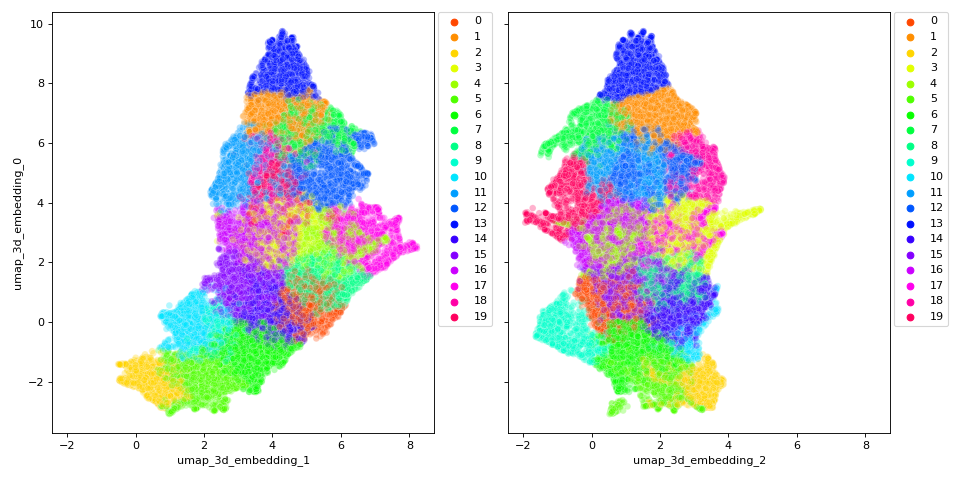

In [85]:
fig,ax=plt.subplots(1,2,figsize=(12,6),sharey=True,sharex=True)
sns.scatterplot(
    x='umap_3d_embedding_1', 
    y='umap_3d_embedding_0',
    hue='k_means_on_3d_umap',
    palette=sns.color_palette("hsv", len(rsp['k_means_on_3d_umap'].unique())),
    data=rsp,
    legend='full',
    alpha=0.3,
    ax=ax[0],
)
sns.scatterplot(
    x='umap_3d_embedding_2', 
    y='umap_3d_embedding_0',
    hue='k_means_on_3d_umap',
    palette=sns.color_palette("hsv", len(rsp['k_means_on_3d_umap'].unique())),
    data=rsp,
    legend='full',
    alpha=0.3,
    ax=ax[1],
)
for i in range(2):
    ax[i].legend(loc='upper left',bbox_to_anchor=(1.01, 1),borderaxespad=0)
fig.tight_layout()

In [86]:
fig = px.scatter_3d(
    rsp, 
    x='umap_3d_embedding_0', 
    y='umap_3d_embedding_1', 
    z='umap_3d_embedding_2',
    color='k_means_on_3d_umap',
    color_continuous_scale='hsv',
)

# optional view positioning parameters (I don't really understand these, just toying with them to get a view I like!)
camera = dict(
    up=dict(x=3, y=1.75, z=0.25),
    eye=dict(x=1.5, y=1.5, z=-0.2)
)

fig.update_layout(
    scene_camera=camera,
    margin=dict(l=30, r=30, t=10, b=10),
    width=1200,
    height=1000,
)
# fig.write_html("/home/dougo/code/dougollerenshaw.github.io/figures_to_share/2020.08.21_k_means_on_umap.html")
fig.show()

In [87]:
# identify dominant dropouts for each cluster
cols_to_search = ['all-images','omissions','pupil','running']
gat.identify_dominant_dropouts(rsp, cluster_column_name='k_means_on_3d_umap', cols_to_search=cols_to_search)

In [88]:
cols_to_plot = [
    'all-images', 
    'omissions', 
    'pupil', 
    'running',
    'cre_line_categorical', 
    'session_id_categorical', 
    'k_means_on_3d_umap', 
    'equipment_name_categorical',
    'targeted_structure_categorical',
    'imaging_depth'
]

# make sure there's a heatmap definition for every column, otherwise the column will plot without a heatmap!
heatmap_defs = [
    {
        'columns':cols_to_plot[:4],
        'cbar_label':'fraction change\nin var explained',
        'cbar_ticks':[-1,0,1],
        'vmin':-1,
        'vmax':1,
        'cmap':'bwr',
    },
    {
        'columns':['cre_line_categorical'],
        'cbar_label':'cre_line',
        'cbar_ticks':[0,1,2],
        'cbar_ticklabels':np.sort(np.unique(rsp['cre_line'])),
        'vmin':-0.5,
        'vmax':2.5,
        'cmap':sns.color_palette("hls", 3),
    },
    {
        'columns':['session_id_categorical'],
        'cbar_label':'session ID',
        'cbar_ticks':[0,1,2,3],
        'cbar_ticklabels':[1,3,4,6],
        'vmin':-0.5,
        'vmax':3.5,
        'cmap':sns.color_palette("Dark2", 4),
    },
    {
        'columns':['k_means_on_3d_umap'],
        'cbar_label':'k-means label',
        'cbar_ticks':np.arange(0,20,2),
        'vmin':0,
        'vmax':19,
        'cmap':sns.color_palette("hsv", 20),
    },
    {
        'columns':['equipment_name_categorical'],
        'cbar_label':'equipment name',
        'cbar_ticks':np.arange(len(rsp['equipment_name_categorical'].unique())),
        'cbar_ticklabels':np.sort(np.unique(rsp['equipment_name'])),
        'vmin':-0.5,
        'vmax':len(rsp['equipment_name_categorical'].unique())-0.5,
        'cmap':sns.color_palette("hls", len(rsp['equipment_name_categorical'].unique())),
    },
    {
        'columns':['targeted_structure_categorical'],
        'cbar_label':'targeted structure',
        'cbar_ticks':np.arange(len(rsp['targeted_structure_categorical'].unique())),
        'cbar_ticklabels':np.sort(np.unique(rsp['targeted_structure'])),
        'vmin':-0.5,
        'vmax':len(rsp['targeted_structure'].unique())-0.5,
        'cmap':sns.color_palette("hls", len(rsp['targeted_structure'].unique())),
    },
    {
        'columns':['imaging_depth'],
        'cbar_label':'imaging_depth',
        'cbar_ticks':[0,100,200,300,400],
        'vmin':0,
        'vmax':400,
        'cmap':'magma',
    },
]

In [89]:
rsp

identifier  Full  all-images  beh_model    change  \
0      1000743008_1003146172   0.0   -0.136583  -0.003512 -0.020345   
1      1000743008_1003146180   0.0   -0.175420   0.000000  0.000000   
2      1000743008_1003146183   0.0   -0.269375   0.000000 -0.021731   
3      1000743008_1003146186   0.0   -0.363167  -0.001300 -0.006254   
4      1000743008_1003146190   0.0   -0.114692  -0.001413 -0.017809   
...                      ...   ...         ...        ...       ...   
46501    995622557_994309976   0.0   -0.429839        NaN  0.000000   
46502    995622557_994309982   0.0   -0.482972        NaN  0.000000   
46503    995622557_994309993   0.0   -0.834681        NaN  0.000000   
46504    995622557_994309997   0.0   -0.486048        NaN  0.000000   
46505    995622557_994310003   0.0   -0.859033        NaN -0.002077   

       correct_rejects  face_motion_energy  false_alarms      hits    image0  \
0            -0.023242           -0.044587     -0.045372 -0.008406 -0.039902   
1             0.000000            0.000000     -0.134485 -0.009179  0.000000   
2            -0.004215           -0.012012     -0.019177 -0.015448 -0.118272   
3            -0.000940           -0.011914      0.000000  0.000000  0.000000   
4             0.000000            0.000000      0.000000 -0.002697 -0.030255   
...                ...                 ...           ...       ...       ...   
46501         0.000000            0.000000           NaN       NaN -0.198485   
46502         0.000000            0.000000           NaN       NaN -0.308801   
46503         0.000000            0.000000           NaN       NaN  0.000000   
46504         0.000000            0.000000           NaN       NaN -0.150321   
46505        -0.036883           -0.037912           NaN       NaN -0.092525   

         image1    image2    image3    image4    image5    image6    image7  \
0     -0.003730  0.000000 -0.006323  0.000000 -0.040977 -0.195053 -0.039067   
1      0.000000 -0.088065 -0.123463 -0.065599 -0.169411 -0.018833 -0.001323   
2     -0.697844  0.000000  0.000000 -0.030756 -0.166234  0.000000 -0.061153   
3     -0.014852  0.000000 -0.319945  0.000000 -0.065473  0.000000  0.000000   
4     -0.052092 -0.032261 -0.203120  0.000000 -0.022724 -0.080326  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
46501  0.000000 -0.305563  0.000000  0.000000  0.000000 -0.244272 -0.051714   
46502  0.000000 -0.011148  0.000000  0.000000  0.000000 -0.221147 -0.069971   
46503  0.000000  0.000000  0.000000  0.000000  0.000000 -0.515454 -0.787927   
46504 -0.103792  0.000000  0.000000  0.000000  0.000000 -0.303773 -0.208704   
46505 -0.681692 -0.073240 -0.879326 -0.947332 -0.961019 -0.568804 -0.230849   

       image_expectation  intercept    misses  model_bias  model_omissions1  \
0              -0.026650  -0.002311 -0.052186   -0.002564         -0.000269   
1              -0.042182  -0.000116  0.000000   -0.000018          0.000000   
2              -0.026695  -0.004989  0.000000   -0.004414         -0.004061   
3              -0.032600   0.000000  0.000000    0.000000          0.000000   
4              -0.041964  -0.000829  0.000000    0.000000          0.000000   
...                  ...        ...       ...         ...               ...   
46501          -0.059831   0.000000  0.000000         NaN               NaN   
46502          -0.055112  -0.001766  0.000000         NaN               NaN   
46503          -0.012968   0.000000  0.000000         NaN               NaN   
46504          -0.067815  -0.004151  0.000000         NaN               NaN   
46505          -0.005068  -0.068583 -0.001820         NaN               NaN   

       model_task0  model_timing1D  omissions  post_lick_bouts  post_licks  \
0        -0.000234        0.000000  -0.176834              0.0   -0.015317   
1         0.000000        0.000000  -0.190825              0.0    0.000000   
2         0.000000        0.000000  -0.208209              0.0    0.0000

<IPython.core.display.Javascript object>


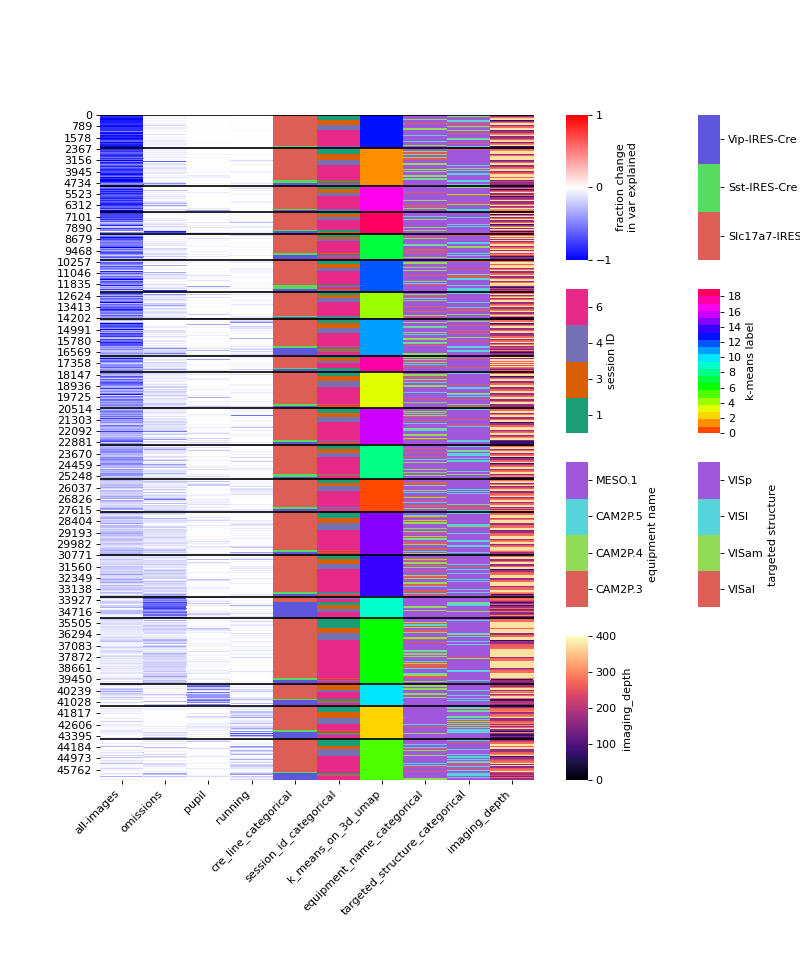

In [92]:
sort_order = ['dominant_dropout','dominant_dropout_median','cre_line_categorical','session_id_categorical','imaging_depth',]
sorted_data = gat.sort_data(rsp, sort_order, cluster_column_name='k_means_on_3d_umap')

fig, axes = vbp.make_multi_cmap_heatmap(
    sorted_data[cols_to_plot], 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.7, 
)
for idx,row in sorted_data.query('cluster_transition').iterrows():
    axes['heatmap'].axhline(idx,color='black')

In [91]:
'cre_line' in rsp.columns

True